In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import scipy.stats as stats

In [2]:
pwd

'C:\\Users\\91843'

In [5]:
df= pd.read_csv('salary.csv')

C:\Users\91843\AppData\Local\Temp\ipykernel_7268\3921266379.py:1: DtypeWarning: Columns (16,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('salary.csv')


In [9]:
# Display basic info
df.info()

# Exploratory Data Analysis (EDA)
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149481 entries, 0 to 149480
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   LAST NAME                149481 non-null  object 
 1   FIRST NAME               149481 non-null  object 
 2   MI                       149481 non-null  object 
 3   CLASS CODE               149481 non-null  object 
 4   CLASS TITLE              149481 non-null  object 
 5   ETHNICITY                149481 non-null  object 
 6   GENDER                   149481 non-null  object 
 7   STATUS                   149481 non-null  object 
 8   EMPLOY DATE              149481 non-null  object 
 9   HRLY RATE                149481 non-null  float64
 10  HRS PER WK               149481 non-null  float64
 11  MONTHLY                  149481 non-null  float64
 12  ANNUAL                   149481 non-null  float64
 13  STATE NUMBER             149481 non-null  int64  
 14  dupl

In [11]:
# Checking for duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)


Number of duplicate rows: 0


In [13]:
# Descriptive statistics
print(df.describe())


           HRLY RATE     HRS PER WK        MONTHLY         ANNUAL  \
count  149481.000000  149481.000000  149481.000000  149481.000000   
mean        0.346488      51.600257    4226.184248   50714.210973   
std         4.211485       3.244661    2093.111691   25117.340292   
min         0.000000       0.000000      50.000000     600.000000   
25%         0.000000      52.000000    3019.840000   36238.080000   
50%         0.000000      52.000000    3720.170000   44642.040000   
75%         0.000000      52.000000    4865.810000   58389.720000   
max       117.788480      57.000000   46125.000000  553500.000000   

       STATE NUMBER  multiple_full_time_jobs  summed_annual_salary  
count  1.494810e+05                 149481.0         149481.000000  
mean   5.651930e+05                      1.0          48066.108721  
std    4.786212e+05                      0.0            586.739833  
min    1.000000e+00                      1.0          18000.000000  
25%    1.133340e+05              

In [15]:
# Checking value counts for categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())



Value counts for LAST NAME:
LAST NAME
SMITH                             1243
GARCIA                            1180
WILLIAMS                          1155
JOHNSON                           1123
MARTINEZ                          1091
                                  ... 
RICHARDSON III                       1
RICHARDS-CURTIS                      1
RICHARD-CROSS                        1
RICE - REYNOLDS                      1
WELLBORN III                         1
Name: count, Length: 38675, dtype: int64

Value counts for FIRST NAME:
FIRST NAME
MICHAEL                           1843
DAVID                             1540
JAMES                             1468
JOHN                              1384
ROBERT                            1239
                                  ... 
LASHONTE                             1
VERONICA A                           1
BRUDAJIA                             1
TYNAISHA                             1
SCOTLAND                             1
Name: count, Length: 

In [17]:
# Data Preprocessing
# Dropping irrelevant columns
columns_to_drop = ['AGENCY', 'AGENCY NAME']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


In [19]:
# Handling missing values - Fill numerical columns with median, categorical with mode
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

In [21]:
# Ordinal Encoding for limited categorical variables
if 'CLASS TITLE' in df.columns:
    if df['CLASS TITLE'].nunique() < 20:
        ordinal_encoder = OrdinalEncoder()
        df['CLASS TITLE'] = ordinal_encoder.fit_transform(df[['CLASS TITLE']])

if 'HRS PER WK' in df.columns:
    ordinal_encoder = OrdinalEncoder()
    df['HRS PER WK'] = ordinal_encoder.fit_transform(df[['HRS PER WK']])


In [25]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Separate low and high-cardinality categorical features
high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > 50]
low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() <= 50]

# One-Hot Encoding for low-cardinality categorical features
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

# Frequency encoding for high-cardinality categorical features
for col in high_cardinality_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].map(freq_map)


In [27]:
print(df.memory_usage(deep=True).sum() / (1024 * 1024), "MB")  # Print memory usage in MB


20.10054874420166 MB


In [29]:
# Encoding categorical variables (excluding ordinal ones)
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [31]:
# Removing highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df = df.drop(columns=to_drop)

In [33]:
# Checking linearity of features with target
def check_linearity(df, target):
    for col in df.columns:
        if col != target:
            slope, intercept, r_value, p_value, std_err = stats.linregress(df[col], df[target])
            print(f"{col}: R-squared = {r_value ** 2:.4f}")

if 'ANNUAL' in df.columns:
    check_linearity(df, 'ANNUAL')

In [35]:
# Scaling continuous features with long tail
if 'ANNUAL' in df.columns:
    scaler = StandardScaler()
    df['ANNUAL'] = scaler.fit_transform(df[['ANNUAL']])
else:
    print("Warning: 'ANNUAL' column not found, skipping scaling step!")


In [37]:
# Distribution of salaries
plt.figure(figsize=(10, 5))
sns.histplot(df['ANNUAL'], bins=50, kde=True)
plt.title("Annual Salary Distribution")
plt.xlabel("Annual Salary")
plt.ylabel("Frequency")
plt.show()

KeyError: 'ANNUAL'

<Figure size 1000x500 with 0 Axes>

In [39]:
# Gender salary comparison
if 'GENDER_MALE' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='GENDER_MALE', y='ANNUAL', data=df)
    plt.title("Annual Salary by Gender")
    plt.show()

In [41]:
# Salary distribution by ethnicity
ethnicity_columns = [col for col in df.columns if 'ETHNICITY' in col]
if ethnicity_columns:
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['ANNUAL'], value_vars=ethnicity_columns, var_name='ETHNICITY', value_name='Value')
    sns.boxplot(x='ETHNICITY', y='ANNUAL', data=df_melted[df_melted['Value'] == 1])
    plt.xticks(rotation=45)
    plt.title("Annual Salary by Ethnicity")
    plt.show()

KeyError: "The following 'id_vars' are not present in the DataFrame: ['ANNUAL']"

<Figure size 1200x600 with 0 Axes>

In [43]:
# Top 10 job titles with highest average salary
if 'CLASS TITLE' in df.columns:
    top_jobs = df.groupby('CLASS TITLE')['ANNUAL'].mean().sort_values(ascending=False).head(10)
    print("Top 10 Job Titles by Average Salary:\n", top_jobs)


C:\Users\91843\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


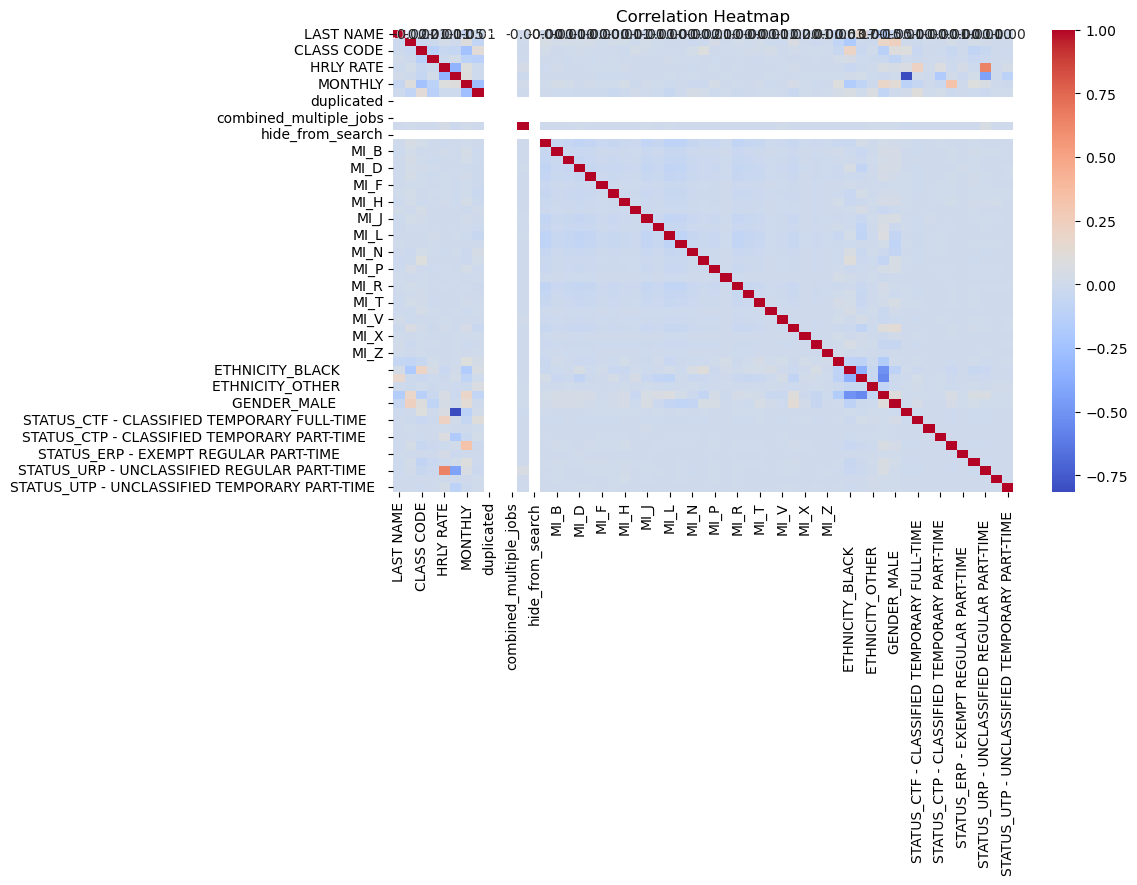

In [45]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()
